In [9]:
import os
import cv2
import numpy as np
import tensorflow as tf
import tflite_runtime.interpreter as tflite

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

#from cauLib import getNumInPic
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from livelossplot import PlotLossesKeras
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report

tf.get_logger().setLevel('ERROR')

In [10]:
img_s = [224,168]
def resizeAndPad(img, size, padColor=0):   
    h, w = img.shape[:2]
    sh, sw = size
    
    # interpolation method
    if h > sh or w > sw: # shrinking image
        interp = cv2.INTER_AREA
    
    else: # stretching image
        interp = cv2.INTER_CUBIC
    
    # aspect ratio of image
    aspect = float(w)/h 
    saspect = float(sw)/sh
    
    if (saspect >= aspect) or ((saspect == 1) and (aspect <= 1)):  # new horizontal image
        new_h = sh
        new_w = np.round(new_h * aspect).astype(int)
        pad_horz = float(sw - new_w) / 2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0
    
    elif (saspect < aspect) or ((saspect == 1) and (aspect >= 1)):  # new vertical image
        new_w = sw
        new_h = np.round(float(new_w) / aspect).astype(int)
        pad_vert = float(sh - new_h) / 2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0
    
    # set pad color
    if len(img.shape) == 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided
        padColor = [padColor]*3
    
    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=padColor)
    
    return scaled_img

def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
    """Return a sharpened version of the image, using an unsharp mask."""
    # For details on unsharp masking, see:
    # https://en.wikipedia.org/wiki/Unsharp_masking
    # https://homepages.inf.ed.ac.uk/rbf/HIPR2/unsharp.htm
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

In [3]:
X = []
Y = []

for d in os.listdir('data/good/'):
    t_img = cv2.imread('data/good/'+d)
    t_img= resizeAndPad(t_img,(img_s[1],img_s[0]),0)
    X.append(t_img)
    Y.append(1)
    
for d in os.listdir('data/bad/'):
    t_img = cv2.imread('data/bad/'+d)
    t_img= resizeAndPad(t_img,(img_s[1],img_s[0]),0)
    X.append(t_img)
    Y.append(0)

In [4]:
X = np.array(X)
Y = np.array(Y)

print(X.shape)
X_train,X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.3, random_state=21)

X_train = X_train.reshape(X_train.shape[0],img_s[1], img_s[0],3) 
X_test = X_test.reshape(X_test.shape[0], img_s[1], img_s[0],3)

X_train = np.array(X_train)
Y_train = np.array(y_train)
X_test = np.array(X_test)
Y_test = np.array(y_test)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

y_train_cat = keras.utils.to_categorical(Y_train, 2)
y_test_cat = keras.utils.to_categorical(Y_test, 2)

(1184, 168, 224, 3)


In [5]:
print(X_test.shape)
print(X_train.shape)
print(y_test_cat.shape)
print(y_train_cat.shape)

(356, 168, 224, 3)
(828, 168, 224, 3)
(356, 2)
(828, 2)


In [6]:
# Add some augmentation layers to change the imputs pictures slightly
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomBrightness(factor=0.5),
    layers.RandomContrast(factor=0.3),
    layers.RandomRotation(factor=0.3)
])


2022-12-01 10:30:47.060446: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 10:30:47.060808: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/martin/anaconda3/envs/apelie/lib/python3.9/site-packages/cv2/../../lib64:/opt/ros/noetic/lib
2022-12-01 10:30:47.060898: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/martin/anaconda3/envs/apelie/lib/python3.9/site-packages/cv2/../../lib64:/opt/ros/noetic/lib
2022-12-01 10:30:47.060976: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

In [17]:
# Create base model with Mobile architecture
base_model = keras.applications.MobileNetV3Large(
    weights='imagenet',  # load pretrained ImageNet weights
    input_shape=(img_s[1], img_s[0], 3),
    include_top=False)  # Delete last layer of the model 

# Freeze pretrained weights
base_model.trainable = False

# Create the imput of our model
inputs= keras.Input(shape=(img_s[1], img_s[0], 3))

#  Augmentation
x = data_augmentation(inputs)

# Add a preprocessing layer specific to this architecture
x = keras.applications.mobilenet_v3.preprocess_input(x)

# Add both models
x = base_model(x, training=False)

# Convert our features vector into a 1-D vector
x = keras.layers.GlobalAveragePooling2D()(x)

# Add a Dropout layer to stop overfitting
x = keras.layers.Dropout(0.3)(x)
1
# Add a final layer with our classes
outputs = keras.layers.Dense(2, activation='softmax')(x)

# Final model
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 168, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 168, 224, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 6, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d_4   (None, 960)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 960)               0         
                                                                 
 dense_4 (Dense)             (None, 2)                 1922

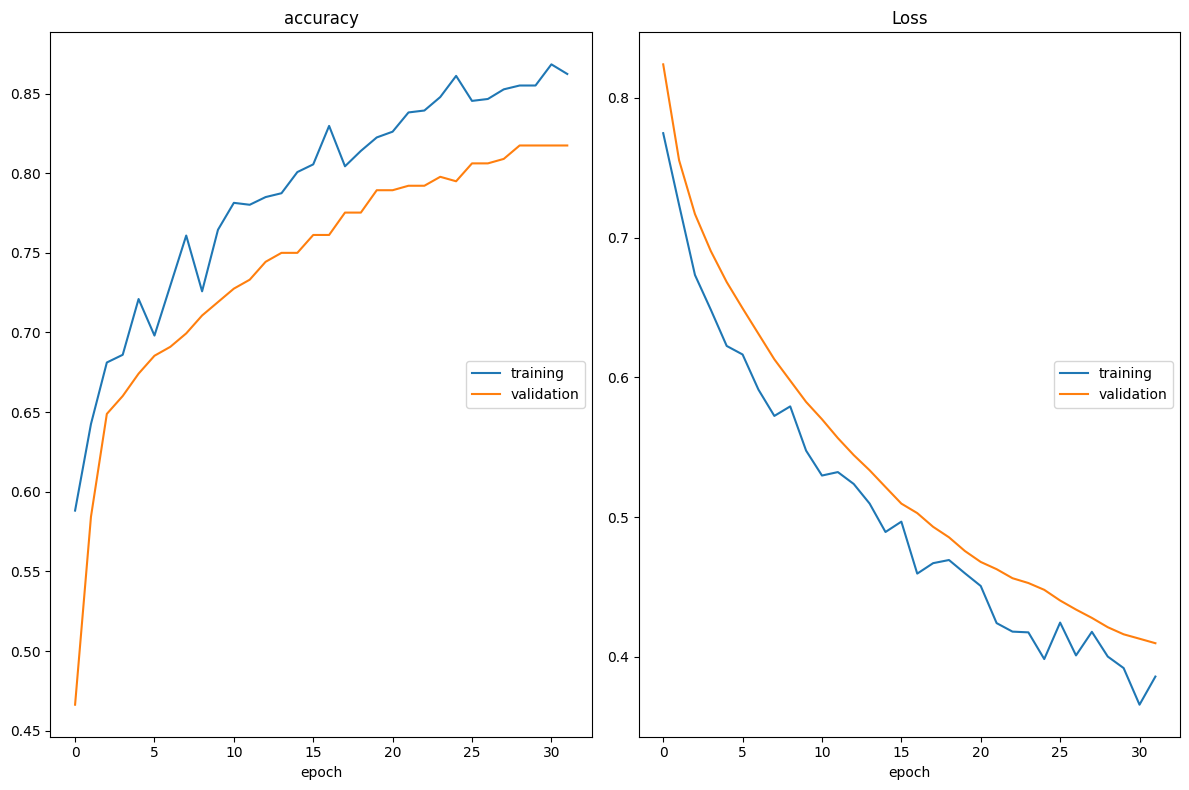

accuracy
	training         	 (min:    0.588, max:    0.868, cur:    0.862)
	validation       	 (min:    0.466, max:    0.817, cur:    0.817)
Loss
	training         	 (min:    0.366, max:    0.775, cur:    0.386)
	validation       	 (min:    0.410, max:    0.824, cur:    0.410)
52/52 [==============================] - 20s 396ms/step - loss: 0.3859 - accuracy: 0.8623 - val_loss: 0.4098 - val_accuracy: 0.8174


In [18]:
opt = keras.optimizers.Adam(learning_rate=0.00005)
my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath= 'model/checkpoint',
        monitor="val_accuracy",
        verbose=0,
        save_best_only=True,
        mode="auto",
        save_freq="epoch",
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        verbose=0,
        mode="auto",
        restore_best_weights=True,
    ),
    PlotLossesKeras()
]

model.compile(
    optimizer=opt,
    loss='binary_crossentropy',
    metrics= ['accuracy']
)

#train the neural network
model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat), batch_size=16, epochs=32, verbose=1,callbacks=my_callbacks)

In [19]:
score = model.evaluate(X_test, y_test_cat, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) 

Test loss: 0.4097800850868225
Test accuracy: 0.817415714263916


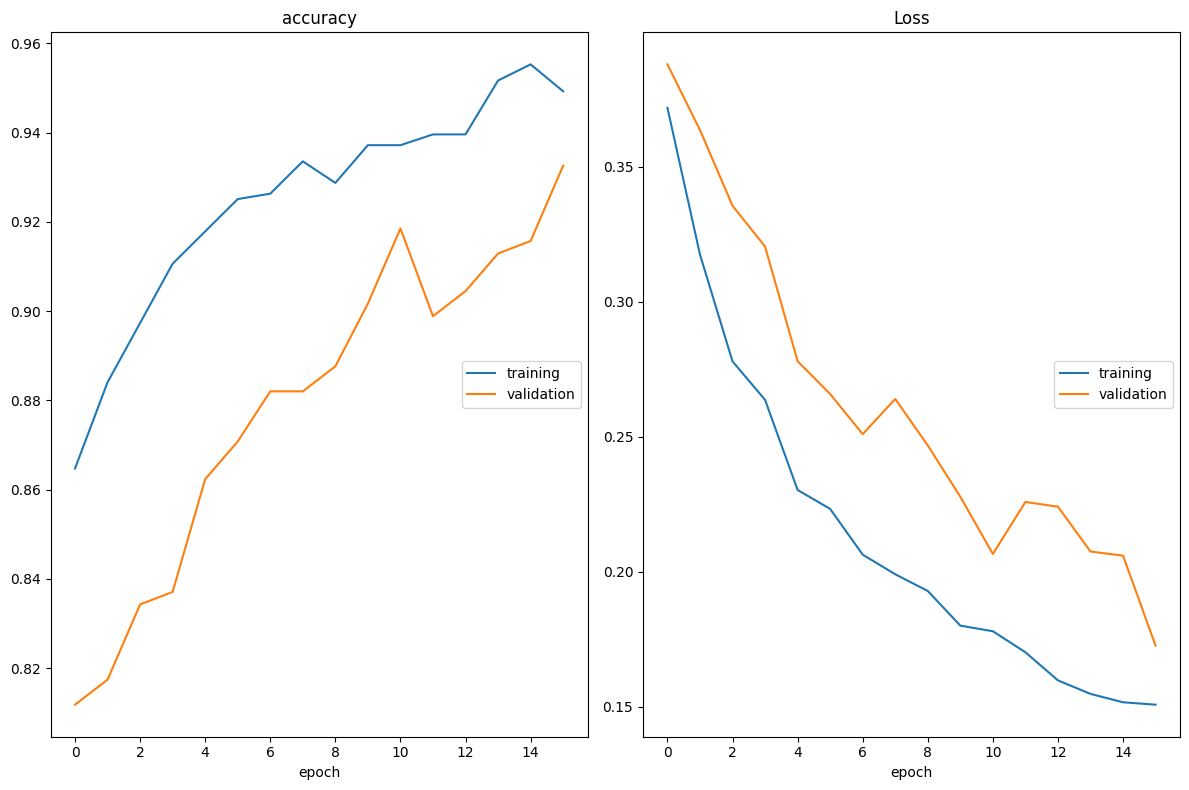

accuracy
	training         	 (min:    0.865, max:    0.955, cur:    0.949)
	validation       	 (min:    0.812, max:    0.933, cur:    0.933)
Loss
	training         	 (min:    0.151, max:    0.372, cur:    0.151)
	validation       	 (min:    0.173, max:    0.388, cur:    0.173)
52/52 [==============================] - 37s 704ms/step - loss: 0.1507 - accuracy: 0.9493 - val_loss: 0.1726 - val_accuracy: 0.9326


In [20]:
base_model.trainable = True
opt = keras.optimizers.Adam(learning_rate=5e-6)

my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath= 'model/checkpoint',
        monitor="val_accuracy",
        verbose=1,
        save_best_only=True,
        save_weights_only=True,
        mode="auto",
        save_freq="epoch",
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        verbose=1,
        mode="auto",
        restore_best_weights=True,
    ),
    PlotLossesKeras()
]

model.compile(
    optimizer=opt,
    loss='binary_crossentropy',
    metrics= ['accuracy']
)

#train the neural network
model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat), batch_size=16, epochs=16, verbose=1,callbacks=[PlotLossesKeras()])

In [21]:
model.save("chikenInPic")
converter = tf.lite.TFLiteConverter.from_saved_model('chikenInPic') # path to the SavedModel directory
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

2022-12-01 11:47:53.181620: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-01 11:47:53.181666: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-12-01 11:47:53.182515: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: chikenInPic
2022-12-01 11:47:53.228403: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-12-01 11:47:53.228437: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: chikenInPic
2022-12-01 11:47:53.344258: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-12-01 11:47:53.405086: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-12-01 11:47:54.694564: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: chikenInPic
2022-12-01 11:47:54.99

In [22]:
interpreter = tflite.Interpreter(model_path = 'model.tflite')

In [23]:
imgage = cv2.imread('data/good/good100.jpg')
imgage = resizeAndPad(imgage,(img_s[1],img_s[0]),0)
imgage = imgage.astype(np.float32)
input_data = imgage[None, :]
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details[0]['shape'])

print(input_data.shape)

[  1 168 224   3]
(1, 168, 224, 3)


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [24]:
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
probability = np.max(output_data)
prediction = (np.argmax(output_data))
print(output_data)
res = model.predict(input_data, verbose=0)
print(res)

[[9.859039e-04 9.990140e-01]]
[[9.8589563e-04 9.9901414e-01]]


In [ ]:
count = 0
if not os.path.exists('output/good/'):
    os.makedirs('output/good/')
if not os.path.exists('output/bad/'):
    os.makedirs('output/bad/')
for i in tqdm(os.listdir('./data/All/')):

    img = cv2.imread('./data/All/'+i)
    imgc = resizeAndPad(img,(img_s[1],img_s[0]),0)
    imgc = imgc[None, :]
    prediction = model.predict(imgc,verbose=False)
    if prediction[0][1] > prediction[0][0]:
        cv2.imwrite('output/good/image-'+str(count)+'.jpg',img)
    else:
        cv2.imwrite('output/bad/image-'+str(count)+'.jpg',img)
        continue
    count += 1

In [26]:
pre = []
for i in X:
    i = i[None, :]
    res = model.predict(i,verbose=0)
    pre.append(np.argmax(res[0]))

print('Confusion:','\n',confusion_matrix(Y,pre),'\n')
print(classification_report(Y, pre))

Confusion: 
 [[451  49]
 [  8 676]] 

              precision    recall  f1-score   support

           0       0.98      0.90      0.94       500
           1       0.93      0.99      0.96       684

    accuracy                           0.95      1184
   macro avg       0.96      0.95      0.95      1184
weighted avg       0.95      0.95      0.95      1184

